In [ ]:
import os, sys
from pathlib import Path

ENV_IS_GOOGLE_COLAB = True if 'google.colab' in str(get_ipython()) else False
os.environ["ENV_IS_GOOGLE_COLAB"] = str(ENV_IS_GOOGLE_COLAB)

if ENV_IS_GOOGLE_COLAB:
  from google.colab import drive
  mountpoint = Path("/content/drive")
  drive.mount(str(mountpoint)) # Mount gdrive to BASE
  base = mountpoint / "MyDrive/SODUCO/article_das_2022" # Adapt this to your situation
  sys.path.append(str(base)) # Add BASE to Python Path
  BASE = Path(base).resolve() # Make BASE absolute
  DATASETS =  BASE / "dataset"
else:
  BASE = Path(os.path.dirname(os.path.realpath("__file__"))).resolve() # If not on GColab, BASE will be the directory of this notebook
  DATASETS = BASE.parent.parent / "dataset"

print(sys.path)
print(BASE)
print(DATASETS)

# 30 - Experiment 1: figures and tables

In [1]:
from pathlib import Path

# PATHS
METRICS_DIR = BASE / "20-experiment_1_metrics" # Or set the path to the metrics extracted from the release archive

In [2]:
import pandas as pd
import re
import os
import json

def compile_metrics(path): 
    rundirs = [f for f in os.listdir(path) if "run_" in f]

    df = pd.DataFrame()
    for run_dir in rundirs:
        run_path = path / run_dir
        nrun = re.search("\d+",run_dir)[0]
        
        files = [f for f in os.listdir(run_path) if "test_" in f]
        sizes = [int(re.search("\d+",f)[0]) for f in files]
        
        for file, size in zip(files,sizes):
            file_path = run_path / file
            dftmp = pd.read_json(file_path, typ='series')
            dftmp = pd.DataFrame([dftmp])
            
            dftmp["trainsize"] = size 
            dftmp["run"] = nrun
            dftmp["trainsize_p"] = round(100 * size / 6373, 1)
            df = pd.concat([df, dftmp])

    return df.groupby(["run","trainsize"]).first()

# Load SpaCy metrics from metrics jsons
spacy_ner = compile_metrics(METRICS_DIR / "21-spacy_ner")
# Align columns with BERT format
spacy_ner.rename(columns={"ents_p":"eval_precision", "ents_r":"eval_recall", "ents_f":"eval_f1"}, inplace=True)

# Load Camembert metrics from metrics jsons
camembert = compile_metrics(METRICS_DIR / "22-camembert")

# Load Camembert-pretrained metrics from metrics JSONS
camembert_pretrained = compile_metrics(METRICS_DIR / "23-camembert_pretrained")

# Create the full table
metrics_raw = pd.concat([spacy_ner, camembert, camembert_pretrained], keys=["spacy_ner","camembert", "camembert_pretrained"])
metrics_raw

token_acc token_p token_r token_f  \
                     run trainsize                                     
spacy_ner            1   49             None    None    None    None   
                         99             None    None    None    None   
                         199            None    None    None    None   
                         398            None    None    None    None   
                         796            None    None    None    None   
...                                      ...     ...     ...     ...   
camembert_pretrained 5   398             NaN     NaN     NaN     NaN   
                         796             NaN     NaN     NaN     NaN   
                         1593            NaN     NaN     NaN     NaN   
                         3186            NaN     NaN     NaN     NaN   
                         6373            NaN     NaN     NaN     NaN   

                                    eval_precision  eval_recall   eval_f1  \
                     run trainsize                                          
spacy_ner            1   49               0.849251     0.882477  0.865546   
                         99               0.875602     0.906949  0.890999   
                         199              0.896541     0.908459  0.902461   
                         398              0.919915     0.912689  0.916288   
                         796              0.924037     0.916918  0.920464   
...                                            ...          ...       ...   
camembert_pretrained 5   398              0.930122     0.945015  0.937509   
                         796              0.929963     0.944713  0.937280   
                         1593             0.943291     0.947281  0.945282   
                         3186             0.939353     0.952266  0.945766   
                         6373             0.939701     0.951057  0.945345   

                                                                        ents_per_type  \
                     run trainsize                                                      
spacy_ner            1   49         {'PER': {'p': 0.9396602226, 'r': 0.949112426, ...   
                         99         {'PER': {'p': 0.9359347699, 'r': 0.950887574, ...   
                         199        {'PER': {'p': 0.9499705709, 'r': 0.95502958580...   
                         398        {'PER': {'p': 0.9633353046, 'r': 0.96390532540...   
                         796        {'PER': {'p': 0.9535294118000001, 'r': 0.95917...   
...                                                                               ...   
camembert_pretrained 5   398                                                      NaN   
                         796                                                      NaN   
                         1593                                                     NaN   
                         3186                                                     NaN   
                         6373                                                     NaN   

                                           speed  trainsize_p  eval_loss  \
                     run trainsize                                         
spacy_ner            1   49         17716.569436          0.8        NaN   
                         99         17612.334244          1.6        NaN   
                         199        15933.750670          3.1        NaN   
                         398        16171.574093          6.2        NaN   
                         796        15404.793203         12.5        NaN   
...                                          ...          ...        ...   
camembert_pretrained 5   398                 NaN          6.2   0.352056   
                         796                 NaN         12.5   0.284139   
                         1593                NaN         25.0   0.316004   
                         3186                NaN         50.0   0.256728   
                         6

# Build the averaged table


In [3]:
# Store p/r/f1 as percentages
eval_ = ["eval_f1","eval_precision","eval_recall"]
metrics = metrics_raw.copy()
metrics[eval_] = metrics_raw[eval_].multiply(100., axis=1)
metrics.head()

token_acc token_p token_r token_f  eval_precision  \
          run trainsize                                                     
spacy_ner 1   49             None    None    None    None       84.925134   
              99             None    None    None    None       87.560158   
              199            None    None    None    None       89.654144   
              398            None    None    None    None       91.991474   
              796            None    None    None    None       92.403714   

                         eval_recall    eval_f1  \
          run trainsize                           
spacy_ner 1   49           88.247734  86.554560   
              99           90.694864  89.099948   
              199          90.845921  90.246098   
              398          91.268882  91.628753   
              796          91.691843  92.046402   

                                                             ents_per_type  \
          run trainsize                                                      
spacy_ner 1   49         {'PER': {'p': 0.9396602226, 'r': 0.949112426, ...   
              99         {'PER': {'p': 0.9359347699, 'r': 0.950887574, ...   
              199        {'PER': {'p': 0.9499705709, 'r': 0.95502958580...   
              398        {'PER': {'p': 0.9633353046, 'r': 0.96390532540...   
              796        {'PER': {'p': 0.9535294118000001, 'r': 0.95917...   

                                speed  trainsize_p  eval_loss  eval_accuracy  \
          run trainsize                                                        
spacy_ner 1   49         17716.569436          0.8        NaN            NaN   
              99         17612.334244          1.6        NaN            NaN   
              199        15933.750670          3.1        NaN            NaN   
              398        16171.574093          6.2        NaN            NaN   
              796        15404.793203         12.5        NaN            NaN   

                         eval_runtime  eval_samples_per_second  \
          run trainsize                                          
spacy_ner 1   49                  NaN                      NaN   
              99                  NaN                      NaN   
              199                 NaN                      NaN   
              398                 NaN                      NaN   
              796                 NaN                      NaN   

                         eval_steps_per_second  epoch  
          run trainsize                                
spacy_ner 1   49                           NaN    NaN  
              99                           NaN    NaN  
              199                          NaN    NaN  
              398                          NaN    NaN  
              796                          NaN    NaN

In [4]:
# Average over runs
averaged = metrics.groupby(level=0).apply(lambda grp: grp.groupby(by="trainsize").mean())
averaged.set_index(["trainsize_p"], append=True,inplace=True)

# Keep just the necessary columns
averaged=averaged[["eval_precision","eval_recall","eval_f1"]]

# Set pretty names
averaged.index.names = ['Model','Trainset Size',"%"]
averaged.rename(columns={"eval_precision": "Precision", "eval_recall": "Recall", "eval_f1":"F1 score"}, errors="raise", inplace=True)
averaged.rename(mapper={"camembert": "CmBERT","camembert_pretrained":"CmBERT+ptrn","spacy_ner":"SpaCy NER"}, errors="ignore", inplace=True, axis=0)
averaged

Precision     Recall   F1 score
Model       Trainset Size %                                     
CmBERT      49            0.8    87.410761  91.604230  89.456831
            99            1.6    88.655054  92.474320  90.522085
            199           3.1    91.544400  93.915408  92.714243
            398           6.2    92.716905  93.891239  93.299850
            796           12.5   93.329497  94.897281  94.106668
            1593          25.0   94.852461  94.854985  94.853115
            3186          50.0   93.854951  95.398792  94.620186
            6373          100.0  95.084464  95.093656  95.086861
CmBERT+ptrn 49            0.8    90.804644  93.592145  92.170513
            99            1.6    91.803274  94.045317  92.909318
            199           3.1    92.863846  94.444109  93.646247
            398           6.2    92.995378  94.649547  93.814482
            796           12.5   92.984962  94.592145  93.781090
            1593          25.0   93.424928  94.782477  94.097957
            3186          50.0   94.120559  95.027190  94.571423
            6373          100.0  93.900409  94.906344  94.400427
SpaCy NER   49            0.8    85.555070  88.586103  87.043738
            99            1.6    87.651826  90.377644  88.992014
            199           3.1    89.967866  90.731118  90.346384
            398           6.2    91.983337  91.722054  91.851640
            796           12.5   92.396052  91.885196  92.139751
            1593          25.0   92.847962  92.755287  92.801576
            3186          50.0   93.089527  93.344411  93.216490
            6373          100.0  93.679900  93.362538  93.519860

# Create the results table
Title: "Experimental results of the NER models performances when trained on varying numbers of examples"

In [5]:
# Filter and transpose to obtain the latex table
latex_table = averaged.stack().unstack(level=[1,2])

# Swap model name and metrics to get a nice table
latex_table = latex_table.swaplevel(0,1).sort_index(level=0)

caption = "F1 score, precision and recall measured on the fine-tuned models CmBERT, CmBERT+ptrn and SpaCy NER in experiment 1 for 8 training sets of increasing sizes."
print(latex_table.to_latex(float_format="%.1f", multirow=True, caption=caption))
latex_table

\begin{table}
\centering
\caption{F1 score, precision and recall measured on the fine-tuned models CmBERT, CmBERT+ptrn and SpaCy NER in experiment 1 for 8 training sets of increasing sizes.}
\begin{tabular}{llrrrrrrrr}
\toprule
       & Trainset Size &  49   &  99   &  199  &  398  &  796  &  1593 &  3186 &  6373 \\
       & \% & 0.8   & 1.6   & 3.1   & 6.2   & 12.5  & 25.0  & 50.0  & 100.0 \\
{} & Model &       &       &       &       &       &       &       &       \\
\midrule
\multirow{3}{*}{F1 score} & CmBERT &  89.5 &  90.5 &  92.7 &  93.3 &  94.1 &  94.9 &  94.6 &  95.1 \\
       & CmBERT+ptrn &  92.2 &  92.9 &  93.6 &  93.8 &  93.8 &  94.1 &  94.6 &  94.4 \\
       & SpaCy NER &  87.0 &  89.0 &  90.3 &  91.9 &  92.1 &  92.8 &  93.2 &  93.5 \\
\cline{1-10}
\multirow{3}{*}{Precision} & CmBERT &  87.4 &  88.7 &  91.5 &  92.7 &  93.3 &  94.9 &  93.9 &  95.1 \\
       & CmBERT+ptrn &  90.8 &  91.8 &  92.9 &  93.0 &  93.0 &  93.4 &  94.1 &  93.9 \\
       & SpaCy NER &  85.6 &  87.7 &

Trainset Size               49         99         199        398        796   \
%                          0.8        1.6        3.1        6.2        12.5    
          Model                                                                
F1 score  CmBERT       89.456831  90.522085  92.714243  93.299850  94.106668   
          CmBERT+ptrn  92.170513  92.909318  93.646247  93.814482  93.781090   
          SpaCy NER    87.043738  88.992014  90.346384  91.851640  92.139751   
Precision CmBERT       87.410761  88.655054  91.544400  92.716905  93.329497   
          CmBERT+ptrn  90.804644  91.803274  92.863846  92.995378  92.984962   
          SpaCy NER    85.555070  87.651826  89.967866  91.983337  92.396052   
Recall    CmBERT       91.604230  92.474320  93.915408  93.891239  94.897281   
          CmBERT+ptrn  93.592145  94.045317  94.444109  94.649547  94.592145   
          SpaCy NER    88.586103  90.377644  90.731118  91.722054  91.885196   

Trainset Size               1593       3186       6373  
%                          25.0       50.0       100.0  
          Model                                         
F1 score  CmBERT       94.853115  94.620186  95.086861  
          CmBERT+ptrn  94.097957  94.571423  94.400427  
          SpaCy NER    92.801576  93.216490  93.519860  
Precision CmBERT       94.852461  93.854951  95.084464  
          CmBERT+ptrn  93.424928  94.120559  93.900409  
          SpaCy NER    92.847962  93.089527  93.679900  
Recall    CmBERT       94.854985  95.398792  95.093656  
          CmBERT+ptrn  94.782477  95.027190  94.906344  
          SpaCy NER    92.755287  93.344411  93.362538

# Create the graphs

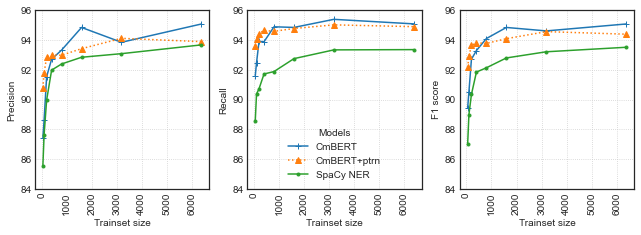

In [7]:
import matplotlib.pyplot as plt


averaged = metrics.groupby(level=0).apply(lambda grp: grp.groupby(by="trainsize").mean())
averaged.rename(columns={"eval_precision": "Precision", "eval_recall": "Recall", "eval_f1":"F1 score"}, errors="raise", inplace=True)
averaged.rename(mapper={"camembert": "CmBERT","camembert_pretrained":"CmBERT+ptrn","spacy_ner":"SpaCy NER"}, errors="ignore", inplace=True, axis=0)


# Keep just the necessary columns
averaged=averaged[["Precision","Recall","F1 score"]]
prec = averaged["Precision"].unstack().T
recall = averaged["Recall"].unstack().T
f1 = averaged["F1 score"].unstack().T

plt.style.use('seaborn-white')  # Nicer plots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex='row', figsize=(9, 3))
fig.tight_layout()


# plot subplots
ls=['+-','^:','.-']
ax1 = prec.plot(ax=axes[0], xlabel="Trainset size", ylabel="Precision", legend=False, style=ls)
ax2 = recall.plot(ax=axes[1], xlabel="Trainset size",ylabel="Recall", legend=False, style=ls)
ax3 = f1.plot(ax=axes[2], xlabel="Trainset size",ylabel="F1 score", legend=False, style=ls)

import numpy as np
plt.xticks(np.arange(0,6400,1000))

plt.setp( ax1.xaxis.get_majorticklabels(), rotation=90 )
plt.setp( ax2.xaxis.get_majorticklabels(), rotation=90 )
plt.setp( ax3.xaxis.get_majorticklabels(), rotation=90 )

# Align y ticks
ax1.set_yticks(ax1.get_yticks())
ax2.set_yticks(ax1.get_yticks())
ax3.set_yticks(ax1.get_yticks())

                           
# Set shared legend above the plots
ax2.legend(loc="lower center",   # Position of legend
           title="Models",  # Title for the legend
           bbox_to_anchor=(0.5, 0)
           )

ax1.grid(linestyle='dotted')
ax2.grid(linestyle='dotted')
ax3.grid(linestyle='dotted')

plt.savefig('experiment-1-models-performances.pdf', dpi=300, format='pdf',bbox_inches='tight')